## Import Library

In [2]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import librosa, librosa.display
import tensorflow as tf
import glob
from tensorflow import keras
from tensorflow.keras import layers
from tqdm.auto import tqdm
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings(action='ignore')

In [27]:
mfcc = pd.read_csv('./train_mfcc50_data.csv')
std = pd.read_csv('./train_mfcc50_std_data.csv')

In [28]:
# mfcc + std feature merge
merge = pd.merge(mfcc, std)
train_df = merge
train_df

,id,age,gender,respiratory_condition,fever_or_muscle_pain,covid19,mfcc_1,mfcc_2,mfcc_3,mfcc_4,...,std_41,std_42,std_43,std_44,std_45,std_46,std_47,std_48,std_49,std_50
0,1,24,female,0,1,0,-274.93472,29.345425,-19.152718,-7.836880,...,3.940978,4.168008,3.704519,3.413724,2.929554,3.248392,3.697180,3.536256,3.146748,2.808870
1,2,51,male,0,0,0,-311.56317,52.478150,-0.098956,-11.070889,...,2.902553,3.375166,2.895491,3.463745,2.674759,3.713707,2.245376,3.168638,2.803887,2.966493
2,3,22,male,0,0,0,-438.29000,46.588910,-22.689060,-3.607528,...,2.923307,2.826745,2.836245,3.008061,4.059071,2.986710,2.961419,2.294150,2.040008,2.326215
3,4,29,female,1,0,0,-368.42612,46.939358,-7.443123,-3.694383,...,3.089176,3.700883,2.960053,3.161702,3.135634,3.220121,3.039690,3.141579,2.571923,2.961397
4,5,23,male,0,0,0,-535.19446,7.165523,-7.422007,2.231186,...,1.806763,2.371473,1.541948,2.607864,1.428324,2.125716,1.746210,1.723021,1.656174,2.108295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3800,3801,53,male,0,0,0,-328.48767,68.190380,-40.383747,2.297682,...,6.964136,9.271381,9.152610,11.020420,7.013804,7.292320,5.920861,6.238069,4.616245,4.588425
3801,3802,25,male,0,0,0,-386.25732,73.931350,-12.114974,-0.500644,...,4.896223,4.390753,5.094110,5.288200,6.331296,8.516347,7.311387,5.686339,4.536681,5.272469
3802,3803,26,female,0,0,0,-347.20593,58.544130,12.969809,27.973340,...,3.594398,2.927548,2.842786,3.129517,3.209869,2.796238,2.546851,3.392260,2.859212,2.692866
3803,3804,27,female,0,0,0,-179.11195,70.697860,-14.571251,-10.143574,...,4.868105,4.600739,4.650938,3.927352,4.996378,4.030235,4.039797,4.363599,5.360180,4.493088


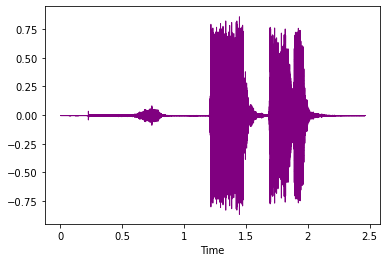

In [29]:
# 코로나 음성자 기침소리 waveshow 시각화
df = mfcc
sample_num=1 # 코로나 음성자 데이터 샘플
filename=str('0000')+str(df.id[sample_num])+str('.wav') #get the filename

y,sr=librosa.load('./wav_dataset/train/'+str(filename))
librosa.display.waveshow(y,sr=sr, x_axis='time', color='purple',offset=0.0)

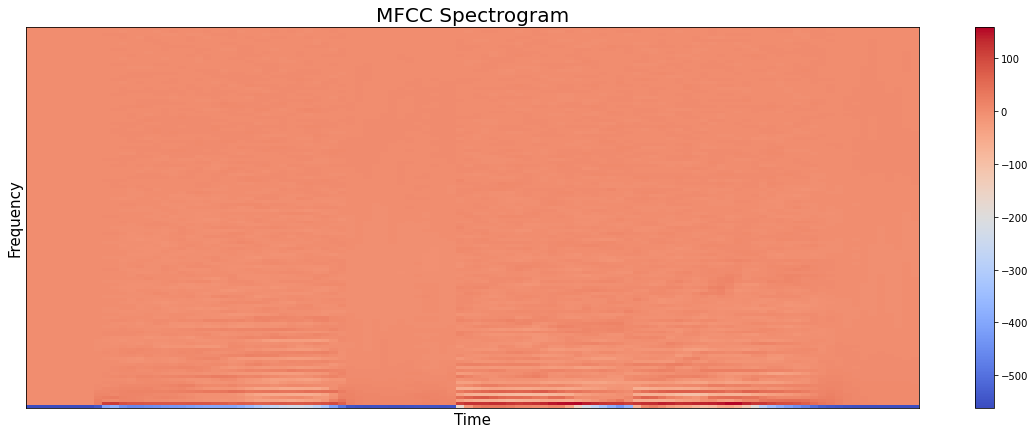

In [30]:
# 코로나 음성자 spectrogram 시각화
sr = 16000

MFCCs = librosa.feature.mfcc(y, sr=sr, n_mfcc=128)
fig, ax = plt.subplots(figsize=(20,7))
librosa.display.specshow(MFCCs,sr=sr)
ax.set_xlabel('Time', fontsize=15)
ax.set_ylabel('Frequency', fontsize=15)
ax.set_title('MFCC Spectrogram', size=20)
plt.colorbar()
plt.show()

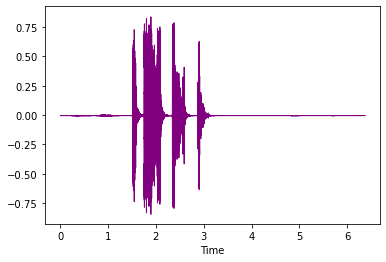

In [31]:
# 코로나 양성자 기침소리 waveshow 시각화
df = mfcc
sample_num=7 # 코로나 양성자 음성 데이터 샘플
filename=str('0000')+str(df.id[sample_num])+str('.wav') #get the filename

y,sr=librosa.load('./wav_dataset/train/'+str(filename))
librosa.display.waveshow(y,sr=sr, x_axis='time', color='purple',offset=0.0)

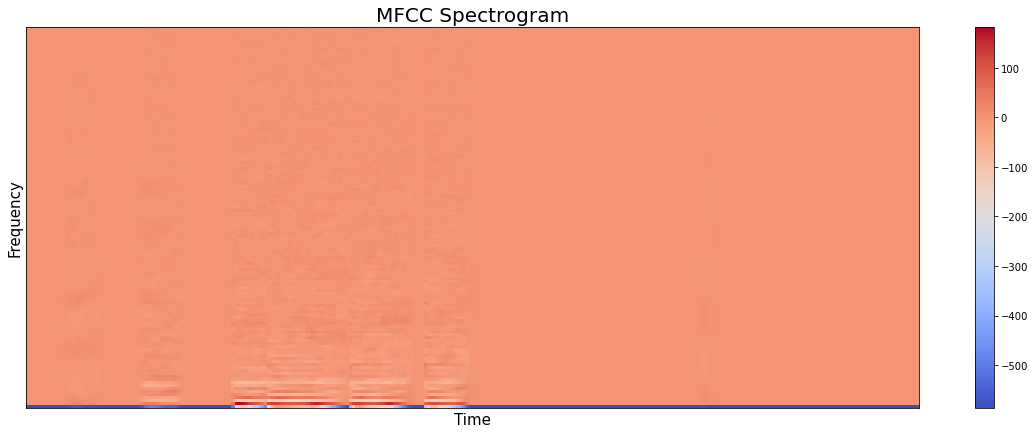

In [32]:
# 코로나 양성자 spectrogram 시각화
# hop_length = 512 #the default spacing between frames
# n_fft = 255 #number of samples
sr = 16000

MFCCs = librosa.feature.mfcc(y, sr=sr, n_mfcc=128)
fig, ax = plt.subplots(figsize=(20,7))
librosa.display.specshow(MFCCs)
ax.set_xlabel('Time', fontsize=15)
ax.set_ylabel('Frequency', fontsize=15)
ax.set_title('MFCC Spectrogram', size=20)
plt.colorbar()
plt.show()

In [60]:
# 학습데이터를 모델의 input으로 들어갈 x와 label로 사용할 y로 분할
x_train = train_df.drop(columns=['id', 'covid19'])
y_train = train_df['covid19']

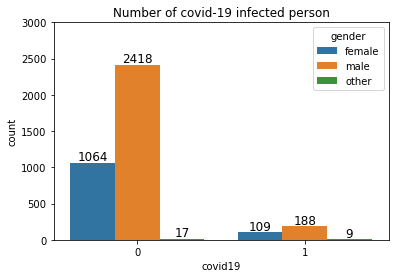

In [61]:
ax = sns.countplot(x='covid19', data = train_df, hue='gender')
plt.title('Number of covid-19 infected person')

# countplot에 값 표시
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 30, height, ha = 'center', size = 12)
ax.set_ylim(0, 3000)
plt.show()

In [62]:
def onehot_encoding(ohe, x):
    # 학습데이터로 부터 fit된 one-hot encoder (ohe)를 받아 transform 시켜주는 함수
    encoded = ohe.transform(x['gender'].values.reshape(-1,1))
    encoded_df = pd.DataFrame(encoded.astype('int'), columns=ohe.categories_[0])
    x = pd.concat([x.drop(columns=['gender']), encoded_df], axis=1)
    return x

# 'gender' column의 경우 추가 전처리가 필요 -> OneHotEncoder 적용
ohe = OneHotEncoder(sparse=False)
ohe.fit(x_train['gender'].values.reshape(-1,1))
x_train = onehot_encoding(ohe, x_train)

In [63]:
# train, validation 데이터 세트 분할
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=123)

In [64]:
# 데이터 크기 확인
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(3044, 106)
(761, 106)
(3044,)
(761,)


In [65]:
x_train = np.array(x_train)
x_val = np.array(x_val)
y_train = np.array(y_train)
y_val = np.array(y_val)

## Modeling Using Keras Dropout

In [80]:
import tensorflow as tf
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.optimizers import SGD, Adam
from keras import metrics

model = Sequential([
    Dense(256, kernel_initializer='normal', activation = "relu", input_shape=(106, )), 
    Dropout(0.5), 
    Dense(1024, kernel_initializer='normal', activation = "relu"),
    Dropout(0.5), 
    Dense(2048, kernel_initializer='normal', activation = "relu"),
    Dropout(0.5), 
    Dense(512, kernel_initializer='normal', activation = "relu"),
    Dropout(0.5), 
    Dense(256, kernel_initializer='normal', activation = "relu"),
    Dropout(0.5),
    Dense(64, kernel_initializer='normal', activation = "relu"),
    Dropout(0.5),
    Dense(16, kernel_initializer='normal', activation = "relu"),
    Dense(1, kernel_initializer='normal', activation = "sigmoid"), 
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 256)               27392     
                                                                 
 dropout_18 (Dropout)        (None, 256)               0         
                                                                 
 dense_25 (Dense)            (None, 1024)              263168    
                                                                 
 dropout_19 (Dropout)        (None, 1024)              0         
                                                                 
 dense_26 (Dense)            (None, 2048)              2099200   
                                                                 
 dropout_20 (Dropout)        (None, 2048)              0         
                                                                 
 dense_27 (Dense)            (None, 512)              

In [81]:
model.compile(loss='binary_crossentropy', 
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8), 
              metrics=[metrics.binary_accuracy, metrics.binary_crossentropy])

In [82]:
history = model.fit(x_train, y_train, epochs=100, 
                          batch_size=200, verbose=1, validation_split=0.2)

Epoch 1/100
13/13 [==============================] - 1s 30ms/step - loss: 0.5241 - binary_accuracy: 0.8686 - binary_crossentropy: 0.5241 - val_loss: 0.5502 - val_binary_accuracy: 0.9245 - val_binary_crossentropy: 0.5502
Epoch 2/100
13/13 [==============================] - 0s 5ms/step - loss: 0.3538 - binary_accuracy: 0.9113 - binary_crossentropy: 0.3538 - val_loss: 0.4147 - val_binary_accuracy: 0.9245 - val_binary_crossentropy: 0.4147
Epoch 3/100
13/13 [==============================] - 0s 5ms/step - loss: 0.3445 - binary_accuracy: 0.9187 - binary_crossentropy: 0.3445 - val_loss: 0.4553 - val_binary_accuracy: 0.9245 - val_binary_crossentropy: 0.4553
Epoch 4/100
13/13 [==============================] - 0s 5ms/step - loss: 0.3273 - binary_accuracy: 0.9187 - binary_crossentropy: 0.3273 - val_loss: 0.5035 - val_binary_accuracy: 0.9245 - val_binary_crossentropy: 0.5035
Epoch 5/100
13/13 [==============================] - 0s 5ms/step - loss: 0.3191 - binary_accuracy: 0.9191 - binary_crossent

13/13 [==============================] - 0s 5ms/step - loss: 0.2917 - binary_accuracy: 0.9191 - binary_crossentropy: 0.2917 - val_loss: 0.3260 - val_binary_accuracy: 0.9245 - val_binary_crossentropy: 0.3260
Epoch 39/100
13/13 [==============================] - 0s 6ms/step - loss: 0.2907 - binary_accuracy: 0.9191 - binary_crossentropy: 0.2907 - val_loss: 0.3228 - val_binary_accuracy: 0.9245 - val_binary_crossentropy: 0.3228
Epoch 40/100
13/13 [==============================] - 0s 5ms/step - loss: 0.2971 - binary_accuracy: 0.9191 - binary_crossentropy: 0.2971 - val_loss: 0.2829 - val_binary_accuracy: 0.9245 - val_binary_crossentropy: 0.2829
Epoch 41/100
13/13 [==============================] - 0s 5ms/step - loss: 0.2873 - binary_accuracy: 0.9191 - binary_crossentropy: 0.2873 - val_loss: 0.3275 - val_binary_accuracy: 0.9245 - val_binary_crossentropy: 0.3275
Epoch 42/100
13/13 [==============================] - 0s 5ms/step - loss: 0.2811 - binary_accuracy: 0.9191 - binary_crossentropy: 0.2

13/13 [==============================] - 0s 5ms/step - loss: 0.2607 - binary_accuracy: 0.9191 - binary_crossentropy: 0.2607 - val_loss: 0.3415 - val_binary_accuracy: 0.9245 - val_binary_crossentropy: 0.3415
Epoch 76/100
13/13 [==============================] - 0s 5ms/step - loss: 0.2600 - binary_accuracy: 0.9191 - binary_crossentropy: 0.2600 - val_loss: 0.3386 - val_binary_accuracy: 0.9245 - val_binary_crossentropy: 0.3386
Epoch 77/100
13/13 [==============================] - 0s 5ms/step - loss: 0.2663 - binary_accuracy: 0.9191 - binary_crossentropy: 0.2663 - val_loss: 0.3112 - val_binary_accuracy: 0.9245 - val_binary_crossentropy: 0.3112
Epoch 78/100
13/13 [==============================] - 0s 6ms/step - loss: 0.2616 - binary_accuracy: 0.9191 - binary_crossentropy: 0.2616 - val_loss: 0.3045 - val_binary_accuracy: 0.9245 - val_binary_crossentropy: 0.3045
Epoch 79/100
13/13 [==============================] - 0s 5ms/step - loss: 0.2617 - binary_accuracy: 0.9191 - binary_crossentropy: 0.2

In [83]:
val_accuracy=model.evaluate(x_val,y_val,verbose=0)
print(val_accuracy[1])

0.9172142148017883


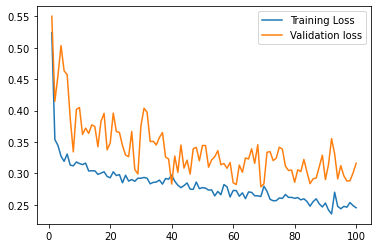

In [84]:
import matplotlib.pyplot as plt

history_dict = history.history #history 속성을 갖고 있음
loss = history_dict['loss'] #혹은 'acc'
val_loss = history_dict['val_loss'] #혹은 'val_acc'

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, label = 'Training Loss')
plt.plot(epochs, val_loss, label = 'Validation loss')
plt.legend()

plt.show()

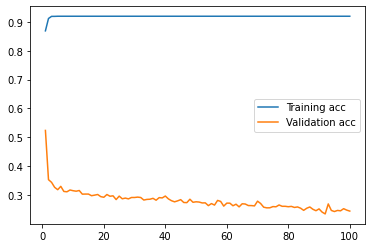

In [88]:
history_dict = history.history #history 속성을 갖고 있음
acc = history_dict['binary_accuracy']
val_acc = history_dict['binary_crossentropy'] 

epochs = range(1, len(loss) + 1)

plt.plot(epochs, acc, label = 'Training acc')
plt.plot(epochs, val_acc, label = 'Validation acc')
plt.legend()

plt.show()

In [89]:
test_mfcc = pd.read_csv('./test_mfcc50_data.csv')
test_std = pd.read_csv('./test_mfcc50_std_data.csv')

In [90]:
# mfcc + std feature merge
merge_test = pd.merge(test_mfcc, test_std)

test_df = merge_test
test_df = test_df.drop(columns=['id'])

# Data Leakage에 유의하여 train data로만 학습된 ohe를 사용
test_df = onehot_encoding(ohe, test_df)
test_df = np.array(test_df)

In [91]:
test_df

array([[48.,  1.,  0., ...,  1.,  0.,  0.],
       [24.,  0.,  0., ...,  1.,  0.,  0.],
       [29.,  0.,  0., ...,  0.,  1.,  0.],
       ...,
       [44.,  0.,  0., ...,  1.,  0.,  0.],
       [25.,  0.,  0., ...,  1.,  0.,  0.],
       [17.,  1.,  1., ...,  1.,  0.,  0.]])

In [163]:
preds = model.predict(test_df)
preds

array([[0.15988457],
       [0.25229165],
       [0.07704685],
       ...,
       [0.23626791],
       [0.204273  ],
       [0.3730081 ]], dtype=float32)

In [164]:
submission = pd.read_csv('wav_dataset/sample_submission.csv')
submission['covid19'] = preds
submission

,id,covid19
0,3806,0.159885
1,3807,0.252292
2,3808,0.077047
3,3809,0.145037
4,3810,0.164802
...,...,...
5727,9533,0.040841
5728,9534,0.162242
5729,9535,0.236268
5730,9536,0.204273


In [165]:
submission['covid19'].value_counts()

0.144100    2
0.069640    2
0.051973    2
0.088387    2
0.159885    1
           ..
0.077957    1
0.046694    1
0.113289    1
0.146966    1
0.373008    1
Name: covid19, Length: 5728, dtype: int64

In [166]:
submission.loc[(submission.covid19 < 0.27), 'covid19'] = 0
submission.loc[(submission.covid19 >= 0.27), 'covid19'] = 1

In [167]:
submission['covid19'].value_counts()

0.0    5224
1.0     508
Name: covid19, dtype: int64

In [168]:
submission

,id,covid19
0,3806,0.0
1,3807,0.0
2,3808,0.0
3,3809,0.0
4,3810,0.0
...,...,...
5727,9533,0.0
5728,9534,0.0
5729,9535,0.0
5730,9536,0.0


In [169]:
submission['covid19'] = submission['covid19'].astype('int')
submission

,id,covid19
0,3806,0
1,3807,0
2,3808,0
3,3809,0
4,3810,0
...,...,...
5727,9533,0
5728,9534,0
5729,9535,0
5730,9536,0


In [170]:
submission.to_csv('./submit_dnn_0623_02.csv', index=False)